In [9]:
# import sys
# sys.path.insert(0, 'visualization.py')
# sys.path.insert(0, 'utils.py')

In [10]:

from visualization import *
from utils import *


# Task n°1


This exercise is about showing measurements made by the Intelligent Road-Side Unit (IRSU) positioned at the center of the intersection:
- 1 point clouds collected by a 32-channel LiDAR

The functions you need to modify are :
-  -> visualization.py
-  -> geometry.py
-  -> utils.py

In [11]:
n_frame = 0
actor = 'infrastructure'

irsu_points = get_point_cloud(n_frame, actor)
irsu_boxes = get_boxes_in_actor_frame(n_frame, actor)
print(irsu_boxes.shape)
box_colors = CLASS_COLORS[irsu_boxes[:, -1].astype(np.int32)]


show_objects(irsu_points[:,:3], irsu_boxes[:,:7], box_colors)

(15, 8)


# Task n°2

This exercise demonstrates how the field of view and perception range of a vehicle can be enhanced by receiving data from other vehicles and the IRSU.

The functions you need to modify are :
-  -> visualization.py
-  -> geometry.py
-  -> utils.py

In [12]:
n_frame = 0
actors = ["ego_vehicle" ,"other_vehicle",   "ego_vehicle_behind","other_vehicle_behind" ,"infrastructure",]#

merged_points = get_available_point_clouds(n_frame, actors)
irsu_boxes = get_available_boxes_in_actor_frame(n_frame, actors)
box_colors = CLASS_COLORS[irsu_boxes[:, -1].astype(np.int32)]

show_objects(merged_points, irsu_boxes[:,:7], box_colors)

# Task n°3

Build a BEV occupancy grid of the environment

A main challenge in perception on point clouds is their unordered nature which hinders the application of the Convolution operation, thus preventing the use of many wonders in the world of image-based perception. An effective way to get around this challenge is to convert point clouds to BEV images. In other word, to look at a point cloud from the top-view which is what you are going to do in this exercise.

The functions you need to modify are :
-  -> visualization.py
-  -> geometry.py
-  -> utils.py

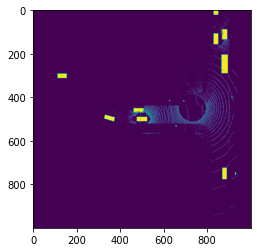

In [13]:

n_frame = 0
actors = ["ego_vehicle" ,"other_vehicle",   "ego_vehicle_behind","other_vehicle_behind","infrastructure",]
merged_points = get_available_point_clouds(n_frame, actors)
irsu_boxes = get_available_boxes_in_actor_frame(n_frame, actors)
box_colors = CLASS_COLORS[irsu_boxes[:, -1].astype(np.int32)]

# ------------------ Get Waypoints that belongs to the ground floor
points_range = np.array([-50, -50, -25, 50, 50, 0.01])  # xmin, ymin, zmin, xmax, ymax, zmax (meters) around ego_vehicle
# threshold on cloud points on z axis
filtered_points = merged_points[np.where(merged_points[:,2] < 0.01)]
# threshold on cloud points on x axis
filtered_points = filtered_points[np.where(filtered_points[:,0] > -50)]
filtered_points = filtered_points[np.where(filtered_points[:,0] < 50)]
# threshold on cloud points on y axis
filtered_points = filtered_points[np.where(filtered_points[:,1] > -50)]
filtered_points = filtered_points[np.where(filtered_points[:,1] < 50)]

show_objects(filtered_points, irsu_boxes[:,:7], box_colors)

# ------------------  Build BEV image
bev_resolution = 0.1 # meters / pixel
bev_imsize = np.ceil((points_range[3: 5] - points_range[:2]) / bev_resolution).astype(int)  # (width, height)

bev_occupancy = np.zeros((bev_imsize[1], bev_imsize[0]))

# ------------------  Project bbox of actors on the image
box_mask = box_to_pixels(irsu_boxes[:,:7], bev_imsize, bev_resolution)
bev_occupancy[box_mask > 0] = 255

# ------------------  Project navigable space on the image
navigable_space = points_to_pixels(filtered_points, bev_imsize, bev_resolution)

for pixel in navigable_space:
    bev_occupancy[pixel[1], pixel[0]] = 150


plt.imshow(bev_occupancy)


# Task n°4: 
Segment points according to object's class